# Resting atmosphere over topography

This test initializes a statically-stable global atmosphere (lapse rate of 6.5 K/km) *at rest* over a 2-km high Schar oscillatory mountain range, without any flow or rotation. The goal here is that the pressure gradients along the sloping surfaces should be in exact hydrostatic balance and no accelerations should be present. (This is where Eta coordinates or cut-cells would excel; this is principally a test for terrain-following coordinates.) The levels are set up to be roughly uniform in dz with height, with 30 levels up to 12 km. This is a C96 (100 km) global domain.

This is test 2-0-0 from [DCMIP 2012](http://www-personal.umich.edu/~cjablono/DCMIP-2012_TestCaseDocument_v1.7.pdf). [FV3 did much better at this test](https://www.gfdl.noaa.gov/fv3/fv3-key-components/), with much less spurious oscillation, than did other dynamical cores; unfortunately this test and its results have vanished into the ether with the whole of DCMIP 2012. (Note that one of the goals of the modern university is the preservation of knowledge. Discuss amongst yourselves.) This test in turn is a variation of that shown in Lin (1997, QJ) in which the finite-volume pressure-gradient force scheme produced far smaller errors than did a traditional finite differencing scheme, which is handicapped by needing to take the small difference between two large quantities. **The FV PGF avoids this problem.**

The results shown here at $\Delta x = $100 km have little sensitivity to nonhydrostatic dynamics, monotonicity, or damping parameters. In particular *these good results are not a consequence of the model diffusivity*. This is very different from our experience at kilometer-scale resolution in which damping parameters have a big effect (see notebook mtn_rest_shear_1km). This strongly implies that lessons learned at kilometer scales may not apply at traditional climate resolutions, and vice-versa. It is a testament to FV3's strengths that it is able to be flexible and robust enough to permit great results in models at both ends (and beyond)---**truly a platform for models across all scales**.

In [1]:
import xarray as xa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker, cm, colors
import cartopy.crs as ccrs
import colorsys
import dask #Chunking will be necessary for the larger datasets

In [2]:
large = 24; med = 20; small = 16
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (14, 6),
          'axes.labelsize': med,
          'axes.titlesize': large,
          'xtick.labelsize': small,
          'ytick.labelsize': small,
          'figure.titlesize': large,
          'axes.titlepad': 6}
plt.rcParams.update(params)

In [3]:
xahyd=xa.open_dataset("/archive/lmh/SHiELD/202103/C96.solo.mtn_rest.hyd/history/0000000000/atmos_4xdaily.nc",decode_times=False)
xahyd_alt=xa.open_dataset("/archive/lmh/SHiELD/202103/C96.solo.mtn_rest.hyd.diff2/history/0000000000/atmos_4xdaily.nc",decode_times=False)
xastat=xa.open_dataset("/archive/lmh/SHiELD/202103/C96.solo.mtn_rest.hyd/history/0000000000/atmos_static.nc",decode_times=False)
xanh=xa.open_dataset("/archive/lmh/SHiELD/202103/C96.solo.mtn_rest/history/0000000000/atmos_4xdaily.nc",decode_times=False)
xanh_alt=xa.open_dataset("/archive/lmh/SHiELD/202103/C96.solo.mtn_rest.nonmono.diff2/history/0000000000/atmos_4xdaily.nc",decode_times=False)

In [4]:
xahyd

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 360, pfull: 30, phalf: 31, time: 24)
Coordinates:
  * time     (time) float64 0.25 0.5 0.75 1.0 1.25 1.5 ... 5.0 5.25 5.5 5.75 6.0
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * pfull    (pfull) float32 211.9 225.1 239.1 253.8 ... 850.6 891.3 933.6 977.5
  * phalf    (phalf) float32 205.4 218.4 232.0 246.3 ... 870.7 912.2 955.3 1e+03
Data variables:
    ucomp    (time, pfull, lat, lon) float32 ...
    vcomp    (time, pfull, lat, lon) float32 ...
    temp     (time, pfull, lat, lon) float32 ...
    pfhy     (time, pfull, lat, lon) float32 ...
    delp     (time, pfull, lat, lon) float32 ...
    hght     (time, pfull, lat, lon) float32 ...
    omega    (time, pfull, lat, lon) float32 ...
    omg500   (time, lat, lon) float32 ...
    ps       (time, lat, lon) float32 ...
Attributes:
    NumFilesInSet:  1
    title:          C96.64bit
    grid_type:      regular
    grid_tile:      N/A
    history:        Mon Aug 23 11:07:21 2021: ncap2 --overwrite -s time=doubl...
    NCO:            netCDF Operators version 4.8.1 (Homepage = http://nco.sf....
    description:    data interpolated from cubed sphere to latlon

Below is a plot of the topography; note that it is designed to cover the whole earth with ripples.

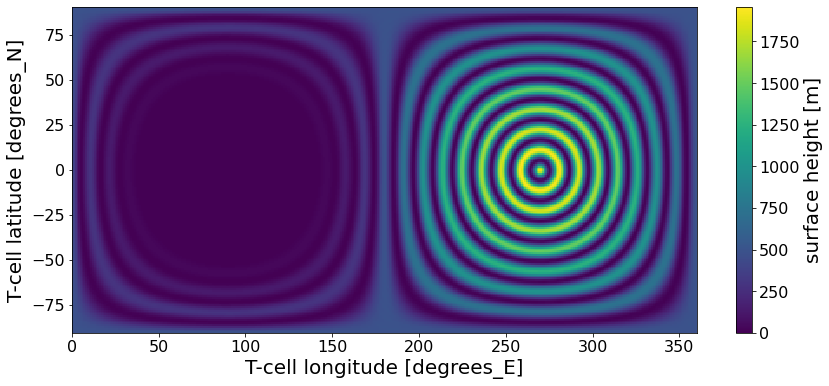

In [5]:
#Show topography
xastat.zsurf.plot(figsize=(14,6))

In [6]:
#A convenient routine.
def plot_topo_z(ax,xx,zs):
    zs2=np.append(zs,[0,0])
    c2 = np.append(xx,[xx[-1],xx[0]])
    ax.fill(c2,zs2,'black')
    #ax.fill(c2,zs2,'darkslategray')

Here we plot cross-sections along the Equator in both Pressure and Height coordinates. No matter what vertical coordinate is used, it is apparent that:

1) The spurious velocities are all *very* small. Note the amplitudes for the color scale.
2) They are very localized around the mountain; spurious gravity waves do not propagate away to contaminate the solution elsewhere.
3) Some small oscillations are visible at higher altitudes and away from the mountain; these are in fact very small and are just due to there being a 0 contour. The 0 contour is plotted as per DCMIP protocol.

Here we plot in true pressure or height instead of on native model surfaces.

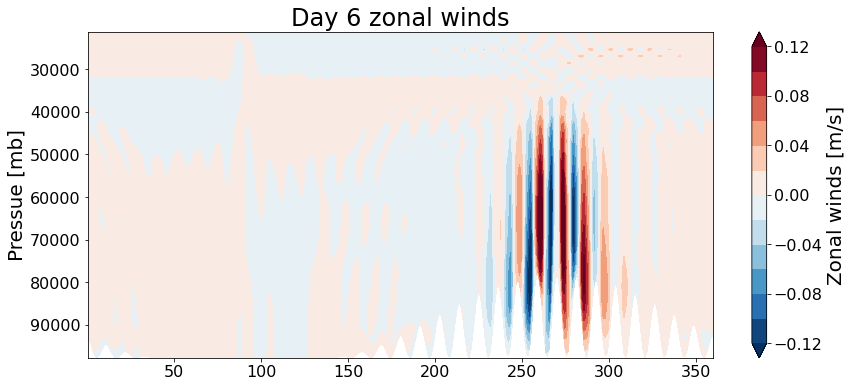

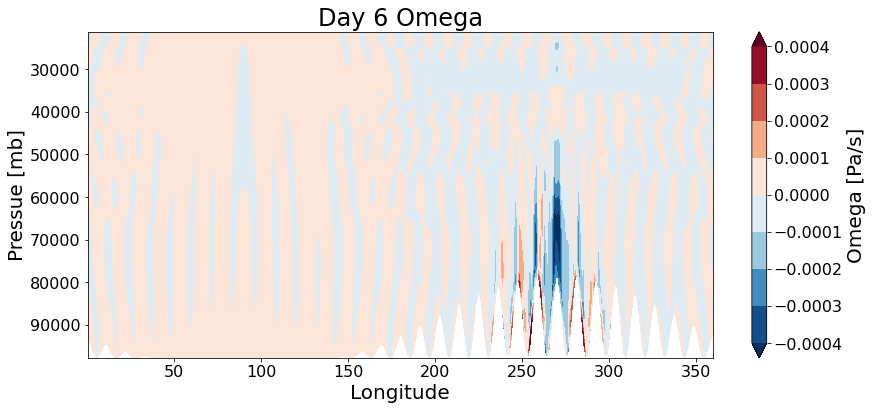

In [7]:
p=xahyd.sel(lat=0,time=6).pfhy.values
lon=xahyd.lon.values
lon=np.tile(lon,(p.shape[0],1))
u=xahyd.sel(lat=0,time=6).ucomp.values
om=xahyd.sel(lat=0,time=6).omega.values


fig=plt.figure(figsize=(14,6))
plt.contourf(lon,p,u,levels=np.arange(-0.12,0.13,0.02),extend="both",cmap="RdBu_r")
plt.gca().invert_yaxis()
plt.gca().set_ylabel("Pressue [mb]")
plt.gca().set_title("Day 6 zonal winds")
plt.colorbar(label="Zonal winds [m/s]")

fig=plt.figure(figsize=(14,6))
plt.contourf(lon,p,om,levels=np.arange(-0.0004,0.00042,0.0001),extend="both",cmap="RdBu_r")
plt.gca().invert_yaxis()
plt.gca().set_ylabel("Pressue [mb]")
plt.gca().set_title("Day 6 Omega")
plt.colorbar(label="Omega [Pa/s]")

plt.gca().set_xlabel("Longitude");

To make clear the hybrid-pressure structure of our vertical coordinate, we plot the layer interfaces (gray lines) and the solutions in height coordinates. Note that the errors are strongly localized to areas of sloping vertical coordinates.

We could artificially reduce the spurious velocities in this test by lowering the height at which the terrain-following coordinate becomes a pure-pressure coordinate. However this would make this test unindicative of real-world performance; in a full-physics model the transition from hybrid to pure-pressure coordinates needs to be in the upper troposphere to avoid issues with pure-pressure coordinates getting too close to topography.

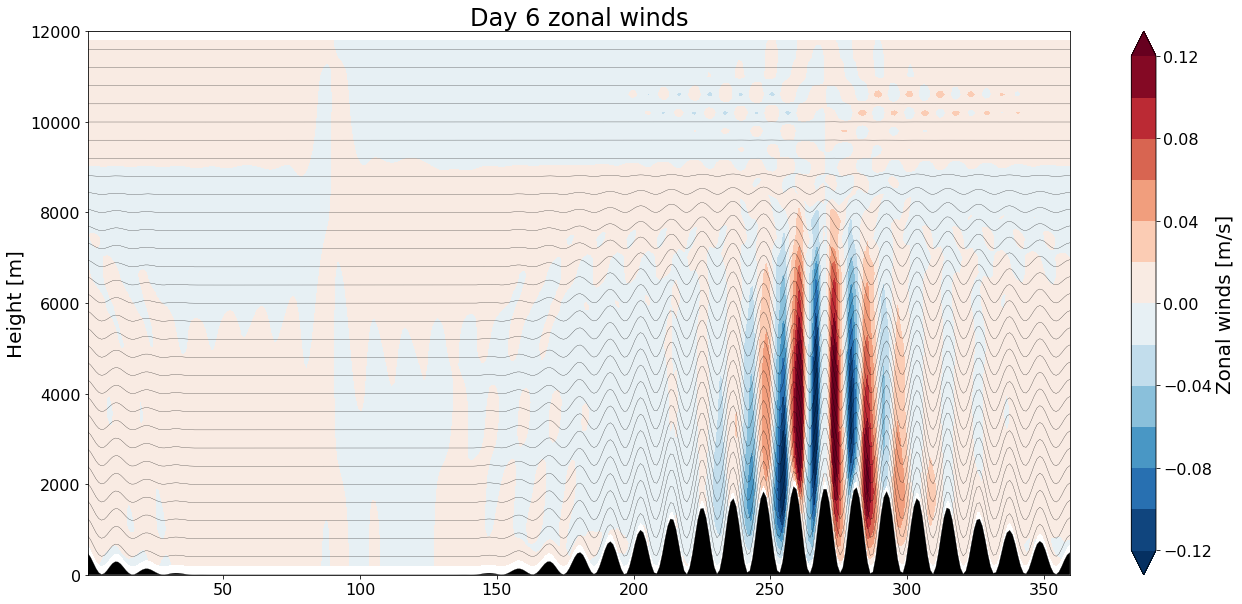

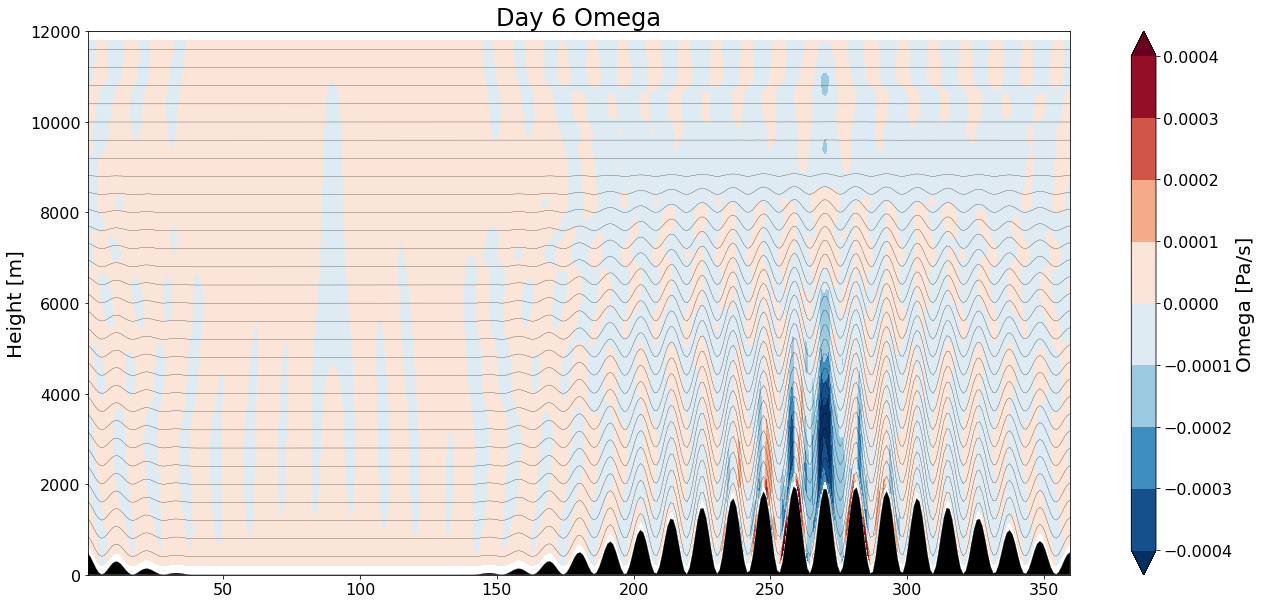

In [8]:
p=xahyd.sel(lat=0,time=6).pfhy.values
z=xahyd.sel(lat=0,time=6).hght.values
lon1d=xahyd.lon.values
lon=np.tile(lon1d,(p.shape[0],1))
delp=xahyd.sel(lat=0,time=6).delp.values
u=xahyd.sel(lat=0,time=6).ucomp.values
T=xahyd.sel(lat=0,time=6).temp.values
om=xahyd.sel(lat=0,time=6).omega.values

zs=xastat.sel(lat=0).zsurf.values

#Compute interface p
(Nz,Nx) = om.shape
ptop=xastat.pk.values[0]
pe = np.zeros((Nz+1,Nx)) + ptop
pe[1:,:] = pe[1:,:] + np.cumsum(delp,axis=0)

#Compute interface z using hydrostatic balance
grav=9.81 #m/s
Rd=287. 
delz=np.diff(np.log(pe),axis=0)*(Rd*T)/grav
zi = np.zeros((Nz+1,Nx)) + zs
zi[:-1,:] = zi[:-1,:] + np.flip(np.cumsum(np.flip(delz,axis=0),axis=0),axis=0)

fig=plt.figure(figsize=(22,10))
plt.contourf(lon,z,u,levels=np.arange(-0.12,0.13,0.02),extend="both",cmap="RdBu_r")
plt.colorbar(label="Zonal winds [m/s]")
plot_topo_z(plt.gca(),lon1d,zs)
plt.plot(lon1d,zi.T,linewidth=0.25,color='k')
plt.gca().set_ylim((0,12000))
plt.gca().set_ylabel("Height [m]")
plt.gca().set_title("Day 6 zonal winds")


fig=plt.figure(figsize=(22,10))
plt.contourf(lon,z,om,levels=np.arange(-0.0004,0.00042,0.0001),extend="both",cmap="RdBu_r")
plt.colorbar(label="Omega [Pa/s]")
plot_topo_z(plt.gca(),lon1d,zs)
plt.plot(lon1d,zi.T,linewidth=0.25,color='k')
plt.gca().set_ylim((0,12000))
plt.gca().set_ylabel("Height [m]")
plt.gca().set_title("Day 6 Omega");


The contour interval does make some small-scale oscillations apparent, such as the apparent "reflections" in $u$ above the mountain range. Below is a plot of the 300-mb (about 9.8 km) $u$: it is apparent that these are indeed very low-amplitude oscillations compared to the larger (but still small) spurious gravity wave response. (The vertical scale is equal to the colorbar range, and the contour intervals are indicated by dotted light lines; where the plotted curve intesects these lines a color transition would be apparent in the plot above.)

Note also that we have no wave-absorbing layer in these runs: upper-level damping is limted to our standard two-level sponge layer. We might be able to tune this to reduce the very small reflections even further but I don't plan to spend that sort of time on this :-)

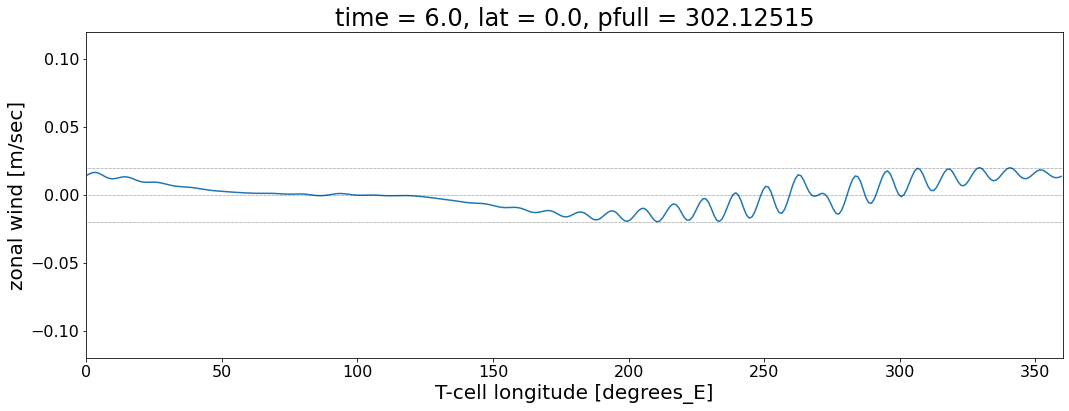

In [15]:
xahyd.sel(lat=0,time=6).isel(pfull=6).ucomp.plot(figsize=(17.5,6))
plt.gca().set_xlim((0,360))
plt.gca().set_ylim((-0.12,0.12))
plt.gca().plot([0,360],[0.02, 0.02],linewidth=0.5,color='k',linestyle=':')
plt.gca().plot([0,360],[-0.02, -0.02],linewidth=0.5,color='k',linestyle=':')
plt.gca().plot([0,360],[0, 0],linewidth=0.5,color='k',linestyle=':')

We can repeat the analysis with the nonhydrostatic solver at the same resolution and vertical levels.

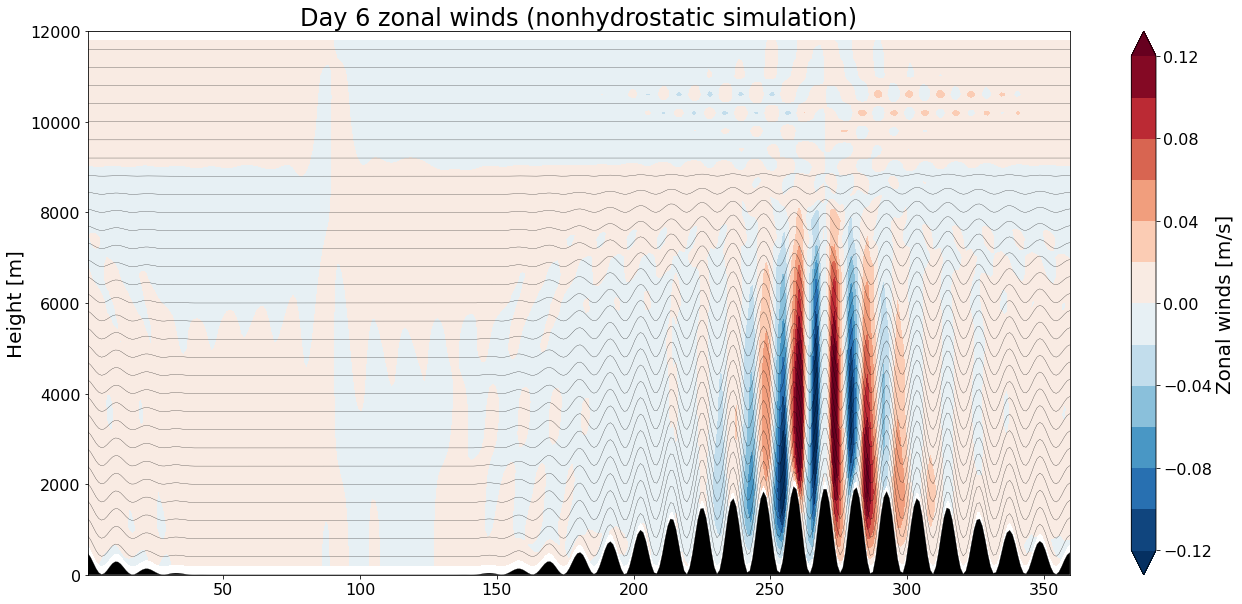

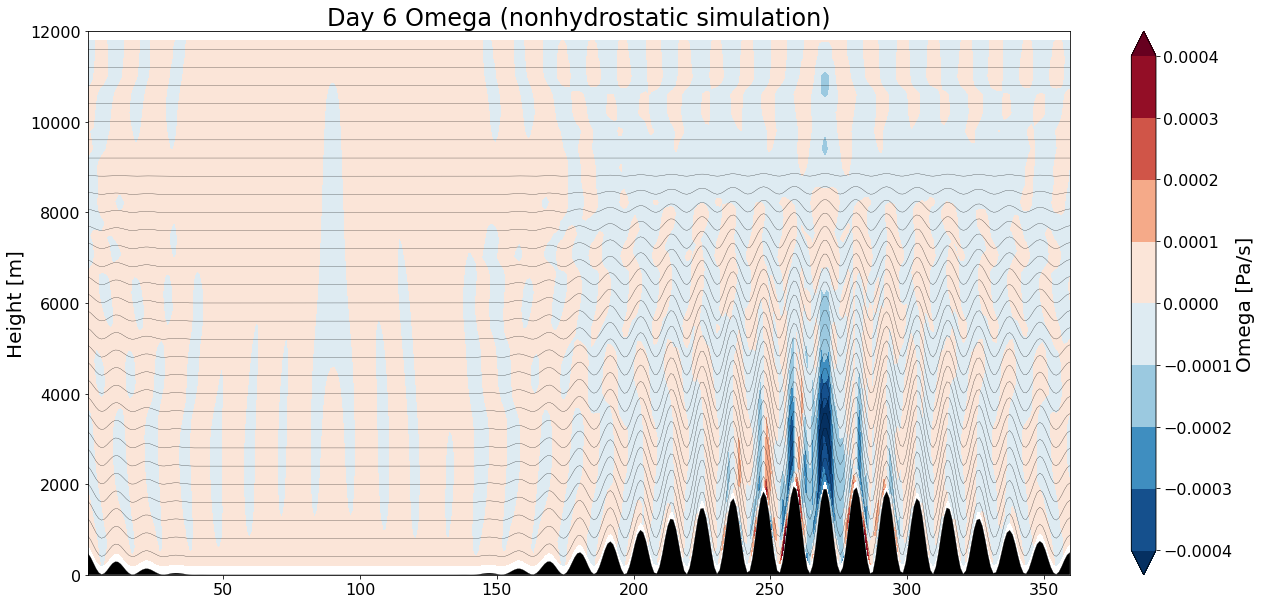

In [10]:
p=xanh.sel(lat=0,time=6).pfnh.values
z=xanh.sel(lat=0,time=6).hght.values
lon1d=xanh.lon.values
lon=np.tile(lon1d,(p.shape[0],1))
delp=xanh.sel(lat=0,time=6).delp.values
u=xanh.sel(lat=0,time=6).ucomp.values
T=xanh.sel(lat=0,time=6).temp.values
om=xanh.sel(lat=0,time=6).omega.values
delz=xanh.sel(lat=0,time=6).delz.values

zs=xastat.sel(lat=0).zsurf.values

#Compute interface z 
(Nz,Nx) = om.shape
zi = np.zeros((Nz+1,Nx)) + zs
zi[:-1,:] = zi[:-1,:] + np.flip(np.cumsum(np.flip(delz,axis=0),axis=0),axis=0)

fig=plt.figure(figsize=(22,10))
plt.contourf(lon,z,u,levels=np.arange(-0.12,0.13,0.02),extend="both",cmap="RdBu_r")
plt.colorbar(label="Zonal winds [m/s]")
plot_topo_z(plt.gca(),lon1d,zs)
plt.plot(lon1d,zi.T,linewidth=0.25,color='k')
plt.gca().set_ylim((0,12000))
plt.gca().set_ylabel("Height [m]")
plt.gca().set_title("Day 6 zonal winds (nonhydrostatic simulation)")


fig=plt.figure(figsize=(22,10))
plt.contourf(lon,z,om,levels=np.arange(-0.0004,0.00042,0.0001),extend="both",cmap="RdBu_r")
plt.colorbar(label="Omega [Pa/s]")
plot_topo_z(plt.gca(),lon1d,zs)
plt.plot(lon1d,zi.T,linewidth=0.25,color='k')
plt.gca().set_ylim((0,12000))
plt.gca().set_ylabel("Height [m]")
plt.gca().set_title("Day 6 Omega (nonhydrostatic simulation)");


Finally, we try simulations in which the explicit diffusion (divergence damping) is reduced from fourth-order to eighth-order; and relax the monotonicity constraint in the nonhydrostatic solver. The solution is little changed from the earlier results; the errors are slightly larger, but the pattern is the same and the bulk of the errors are still tied to the mountain ridge. (The relaxation of the monotonicity constraint has virtually no effect.) This is again very different from our experience at $\Delta x = $1 km.

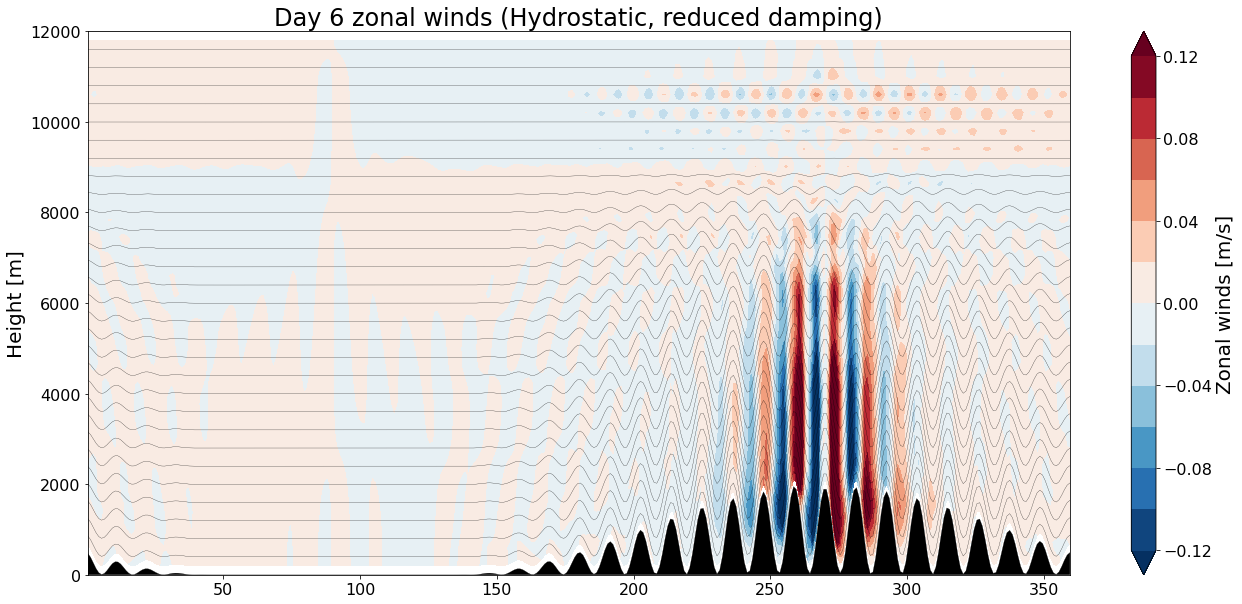

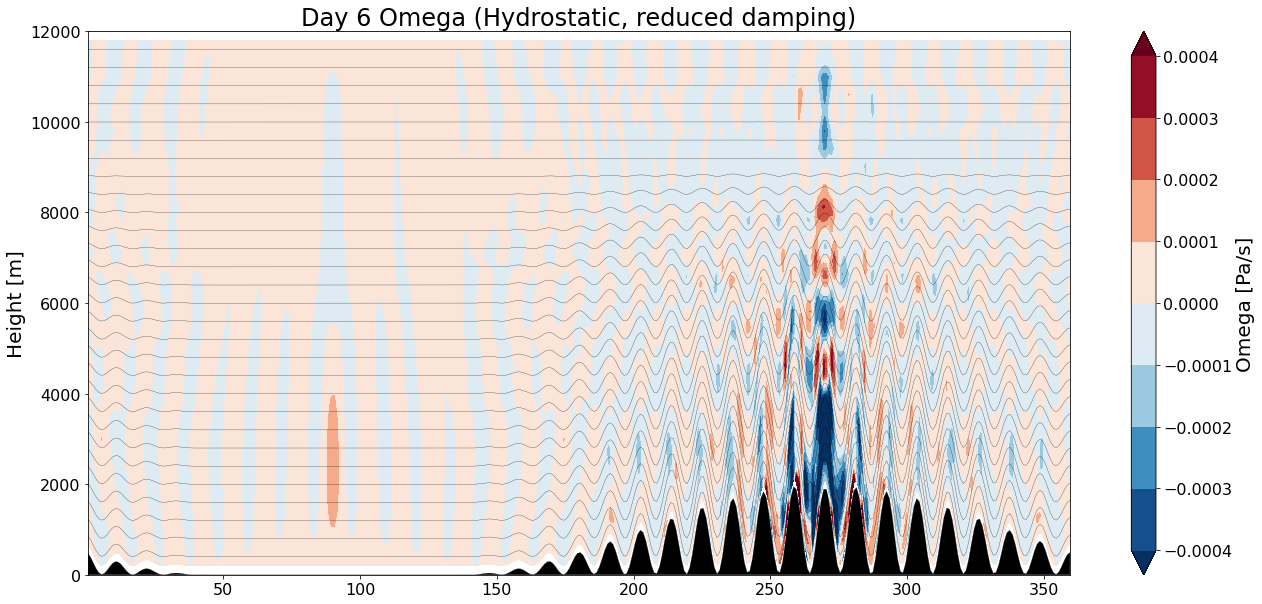

In [12]:
p=xahyd_alt.sel(lat=0,time=6).pfhy.values
z=xahyd_alt.sel(lat=0,time=6).hght.values
lon1d=xahyd_alt.lon.values
lon=np.tile(lon1d,(p.shape[0],1))
delp=xahyd_alt.sel(lat=0,time=6).delp.values
u=xahyd_alt.sel(lat=0,time=6).ucomp.values
T=xahyd_alt.sel(lat=0,time=6).temp.values
om=xahyd_alt.sel(lat=0,time=6).omega.values

zs=xastat.sel(lat=0).zsurf.values

#Compute interface p
(Nz,Nx) = om.shape
ptop=xastat.pk.values[0]
pe = np.zeros((Nz+1,Nx)) + ptop
pe[1:,:] = pe[1:,:] + np.cumsum(delp,axis=0)

#Compute interface z using hydrostatic balance
grav=9.81 #m/s
Rd=287. 
delz=np.diff(np.log(pe),axis=0)*(Rd*T)/grav
zi = np.zeros((Nz+1,Nx)) + zs
zi[:-1,:] = zi[:-1,:] + np.flip(np.cumsum(np.flip(delz,axis=0),axis=0),axis=0)

fig=plt.figure(figsize=(22,10))
plt.contourf(lon,z,u,levels=np.arange(-0.12,0.13,0.02),extend="both",cmap="RdBu_r")
plt.colorbar(label="Zonal winds [m/s]")
plot_topo_z(plt.gca(),lon1d,zs)
plt.plot(lon1d,zi.T,linewidth=0.25,color='k')
plt.gca().set_ylim((0,12000))
plt.gca().set_ylabel("Height [m]")
plt.gca().set_title("Day 6 zonal winds (Hydrostatic, reduced damping)")


fig=plt.figure(figsize=(22,10))
plt.contourf(lon,z,om,levels=np.arange(-0.0004,0.00042,0.0001),extend="both",cmap="RdBu_r")
plt.colorbar(label="Omega [Pa/s]")
plot_topo_z(plt.gca(),lon1d,zs)
plt.plot(lon1d,zi.T,linewidth=0.25,color='k')
plt.gca().set_ylim((0,12000))
plt.gca().set_ylabel("Height [m]")
plt.gca().set_title("Day 6 Omega (Hydrostatic, reduced damping)");


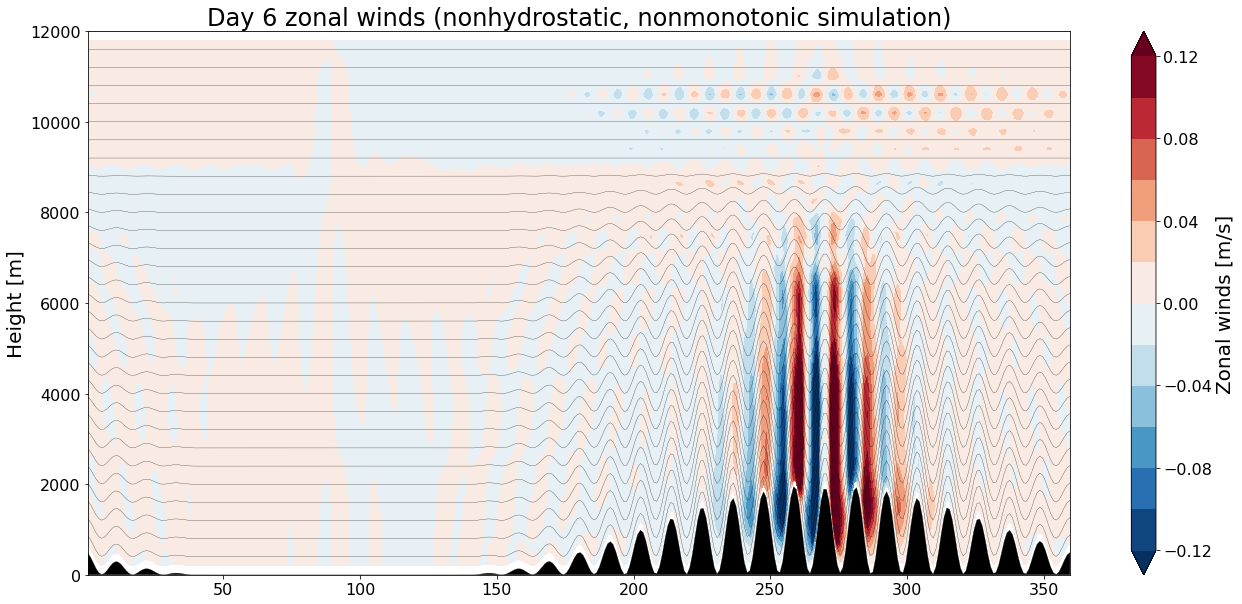

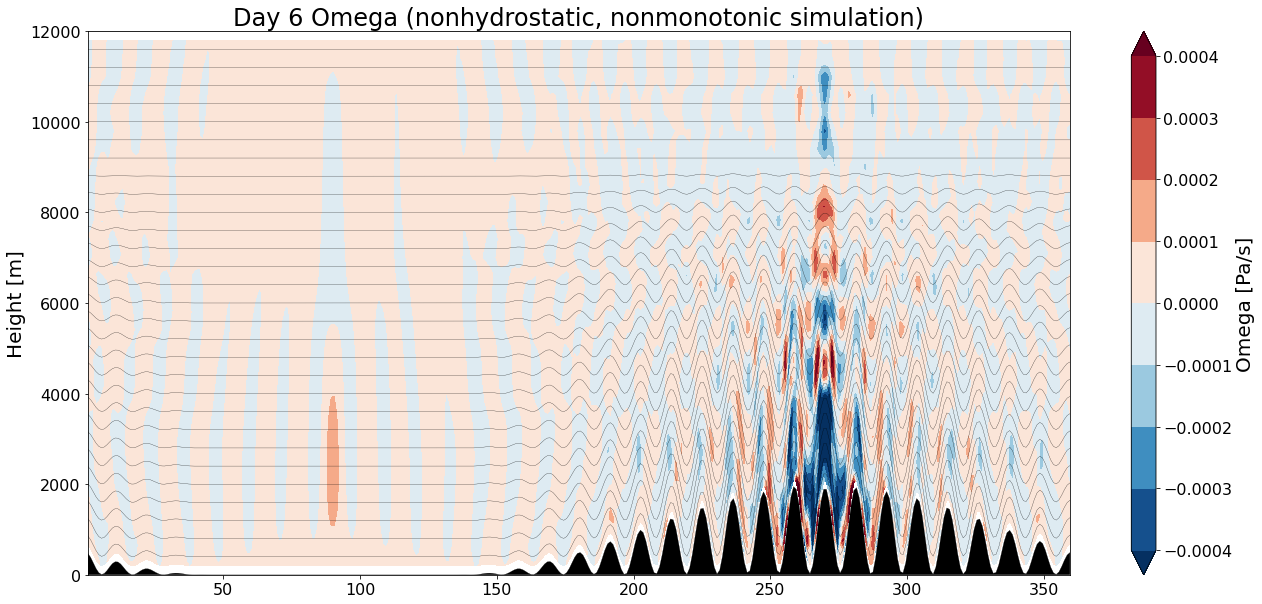

In [11]:
p=xanh_alt.sel(lat=0,time=6).pfnh.values
z=xanh_alt.sel(lat=0,time=6).hght.values
lon1d=xanh_alt.lon.values
lon=np.tile(lon1d,(p.shape[0],1))
delp=xanh_alt.sel(lat=0,time=6).delp.values
u=xanh_alt.sel(lat=0,time=6).ucomp.values
T=xanh_alt.sel(lat=0,time=6).temp.values
om=xanh_alt.sel(lat=0,time=6).omega.values
delz=xanh_alt.sel(lat=0,time=6).delz.values

zs=xastat.sel(lat=0).zsurf.values

#Compute interface z 
(Nz,Nx) = om.shape
zi = np.zeros((Nz+1,Nx)) + zs
zi[:-1,:] = zi[:-1,:] + np.flip(np.cumsum(np.flip(delz,axis=0),axis=0),axis=0)

fig=plt.figure(figsize=(22,10))
plt.contourf(lon,z,u,levels=np.arange(-0.12,0.13,0.02),extend="both",cmap="RdBu_r")
plt.colorbar(label="Zonal winds [m/s]")
plot_topo_z(plt.gca(),lon1d,zs)
plt.plot(lon1d,zi.T,linewidth=0.25,color='k')
plt.gca().set_ylim((0,12000))
plt.gca().set_ylabel("Height [m]")
plt.gca().set_title("Day 6 zonal winds (nonhydrostatic, nonmonotonic simulation)")


fig=plt.figure(figsize=(22,10))
plt.contourf(lon,z,om,levels=np.arange(-0.0004,0.00042,0.0001),extend="both",cmap="RdBu_r")
plt.colorbar(label="Omega [Pa/s]")
plot_topo_z(plt.gca(),lon1d,zs)
plt.plot(lon1d,zi.T,linewidth=0.25,color='k')
plt.gca().set_ylim((0,12000))
plt.gca().set_ylabel("Height [m]")
plt.gca().set_title("Day 6 Omega (nonhydrostatic, nonmonotonic simulation)");


We can quantify the degree of error by computing the global kinetic energy. Note that there is virtually no difference between the hydrostatic and nonhydrostatic values. Reducing the damping only increases the error about 15% above that of the stronger damping case, indicating the robustness of our result.

In [13]:
KEhyd=0.5*xahyd.delp*(xahyd.ucomp**2 + xahyd.vcomp**2)/grav
KEhyd_alt=0.5*xahyd_alt.delp*(xahyd_alt.ucomp**2 + xahyd_alt.vcomp**2)/grav
KEnh=0.5*xanh.delp*(xanh.ucomp**2 + xanh.vcomp**2 + xanh.w**2)/grav
KEnh_alt=0.5*xanh_alt.delp*(xanh_alt.ucomp**2 + xanh_alt.vcomp**2 + xanh_alt.w**2)/grav

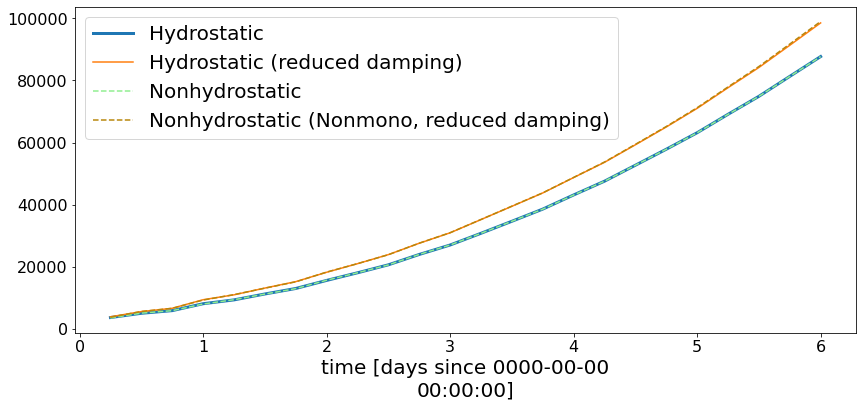

In [14]:
KEhyd.sum(dim=("pfull","lat","lon")).plot(label="Hydrostatic",linewidth=3)
KEhyd_alt.sum(dim=("pfull","lat","lon")).plot(label="Hydrostatic (reduced damping)")
KEnh.sum(dim=("pfull","lat","lon")).plot(label="Nonhydrostatic",linestyle="--",color="lightgreen")
KEnh_alt.sum(dim=("pfull","lat","lon")).plot(label="Nonhydrostatic (Nonmono, reduced damping)",linestyle="--",color="darkgoldenrod")
plt.gca().legend()